# **Source Code for Wine Recommender**

## Summary

This notebook contains the full code in building the Wine Recommender System. It includes:
- Data Cleaning and Preprocessing
- Model Building
- Model Evaluation
- Model Interpretation
- Model Comparison

This project aims to simplify the process for beginners to embark on their journey of wine drinking. One of the features that were added to make the choosing of wine easier was:
- Instead of the user giving the specific name of grapes used, the number of grape(s) that is/was used to make the wine is/was considered instead.

Ensemble classification models such as Random Forest and XGBoost as a well as neural network such as Multi-Layer Perceptron were chosen to build the Recommender System. The models were trained, tested and validated and subsequently evaluated using a confusion matrix and classification report. Model performance using AUC as the scoring metric and chose the best performing model: Random Forest.

## Importing Packages

In [3]:
import pandas as pd
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn import tree

from xgboost import XGBClassifier, plot_importance

# To ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")


## Importing Dataset

In [4]:
df = pd.read_csv('XWines_Full_100K_wines.csv')

## Data Cleaning

### Grapes

In [5]:
# creating a function to remove square brackets and quotation marks
# to be used on Grapes, Harmonize and Vintages
# inputs: data is the dataframe, column_names is the name of the column (string) or list
def clean_column(data, column_names):
    
    for column_name in column_names:

        if column_name in ['Grapes', 'Harmonize']:
            # extracting all words inside 
            data[column_name] = data[column_name].apply(lambda x: re.findall(r"'(.*?)'", x))

            # convert the list of words back to a string
            data[column_name] = data[column_name].apply(lambda x: ', '.join(x))
        
        else: 
            # removing the square brackets
            data[column_name] = data[column_name].apply(lambda x: str(x).strip('[]'))

    return data


df = clean_column(df, ['Grapes', 'Harmonize', 'Vintages'])

In [6]:
# creating function to get the counts
# inputs: data is the dataframe, columns_name are the list of columns to get the counts

def get_counts(data, column_names):
    for column_name in column_names:
        data[column_name] = data[column_name].apply(lambda x: len(x.split(', ')))

    return data

df = get_counts(df, ['Grapes'])

### Harmonize

In [7]:
unique_foods = df['Harmonize'].str.split(', ', expand=True).stack().unique()

unique_foods

array(['Pork', 'Rich Fish', 'Shellfish', 'Beef', 'Barbecue', 'Codfish',
       'Pasta', 'Pizza', 'Cheese', 'Lamb', 'Poultry', 'Sweet Dessert',
       'Game Meat', 'Veal', 'Spicy Food', 'Maturated Cheese',
       'Hard Cheese', 'Vegetarian', 'Appetizer', 'Snack', 'Fish',
       'Citric Dessert', 'Mushrooms', 'Soft Cheese', 'Grilled', 'Soufflé',
       'Cured Meat', 'Seafood', 'Risotto', 'Medium-cured Cheese', 'Salad',
       'Lean Fish', 'Fruit Dessert', 'Dessert', 'Meat', 'Fruit',
       'Blue Cheese', 'Chicken', 'Mild Cheese', 'Chocolate', 'Ham',
       'Cake', 'Yakissoba', 'Sashimi', 'Curry Chicken', 'Sushi',
       'Baked Potato', 'Goat Cheese', 'Beans', 'Lasagna',
       'Eggplant Parmigiana', 'Aperitif', 'Chestnut', 'French Fries',
       'Tomato Dishes', 'Dried Fruits', 'Spiced Fruit Cake',
       'Light Stews', 'Duck', 'Asian Food', 'Cream', 'Cookies',
       'Cold Cuts', 'Roast', 'Tagliatelle', 'Paella'], dtype=object)

In [8]:
# re-classifying similar types of foods with the similar names into same categories
red_meat = ['Beef', 'Pork', 'Lamb', 'Veal', 'Meat', 'Ham', 'Red Meat']
white_meat = ['Chicken', 'Poultry', 'Duck', 'Cold Cuts']
cheese = ['Mild Cheese', 'Medium-cured Cheese', 'Cheese', 'Soft Cheese', 'Maturated Cheese', 'Hard Cheese', 'Goat Cheese', 'Blue Cheese']
seafood = ['Shellfish', 'Rich Fish', 'Lean Fish', 'Fish', 'Codfish', 'Seafood']
italian = ['Pasta', 'Risotto', 'Tagliatelle', 'Lasagna', 'Eggplant Parmigiana', 'Pizza']
dessert = ['Sweet Dessert', 'Fruit Dessert', 'Dessert', 'Citric Dessert', 'Cake', 'Soufflé', 'Chocolate', 'Spiced Fruit Cake']
vegetarian = ['Vegetarian', 'Mushrooms', 'Salad', 'Beans', 'Baked Potato', 'Chestnut']
snacks = ['Snack', 'French Fries', 'Fruit', 'Cookies']
others = ['Sushi', 'Sashimi', 'Yakissoba', 'Asian Food', 'Roast', 'Tomato Dishes', 'Cream', 'Curry Chicken', 'Barbecue', 'Light Stews', 'Paella', 'Grilled', 'Dried Fruits']
appetizer = ['Appetizer', 'Aperitif']

# checking if all other categories except Game Meat, Cured Meat and Spicy Food are classified
# total 67 (64 + 3)
# len(red_meat) + len(white_meat) + len(cheese) + len(seafood) + len(italian) + len(dessert) + len(vegetarian) + len(snacks) + len(others) + len(appetizer)

In [9]:
list_of_lists = [red_meat, white_meat, cheese, seafood, italian, dessert, vegetarian, snacks, others, appetizer]
names = ['Red Meat', 'White Meat', 'Cheese', 'Seafood', 'Italian', 'Dessert', 'Vegetarian', 'Snacks', 'Appetizer', 'Others']

# define a function to re-assign the categories for each row
def reassign_categories(row):
    # splitting the food in the string and making it a list
    food_list = row.split(', ')

    # iterate through the list and re-assign the categories
    for i in range(len(food_list)):
        for lst, name in zip(list_of_lists, names):
            if food_list[i] in lst:
                food_list[i] = name

    # remove repeated food categories for each row
    new_row = list(set(food_list))

    # joining the list back into a string
    new_row = ', '.join(new_row)

    return new_row

# apply the function to each row of the DataFrame
df['Harmonize'] = df['Harmonize'].apply(reassign_categories)

### Body

In [10]:
# removing '-bodied' from body column
df['Body'] = df['Body'].str.replace('-bodied', '')

### Type

In [11]:
# replace dessert/port to just dessert wine
df['Type'] = df['Type'].str.replace('Dessert/Port', 'Dessert')

### Countries

In [12]:
# getting countries that appeared more than 100 times
country_counts = df['Country'].value_counts()
filtered_countries = country_counts[country_counts > 100]
df = df[df['Country'].isin(filtered_countries.index)]

In [13]:
# splitting data into catalogue and training data
df = df.sample(frac = 1, random_state = 100)
catalogue = df[:80000]
df = df[80000:]

## Model Training

In [14]:
df = df[['Type', 'Grapes', 'Harmonize', 'ABV', 'Body', 'Acidity', 'Country']]

In [15]:
# The harmonize column needs to be one-hot encoded seperately since each row can contain more than 1 food type
# If done wrongly, the encoding will be wrong
# For example: a row can contain 'Seafood, Red Meat'. If not done separately, 'Seafood, Red Meat' will be considered a category on its own, instead of 'Seafood' and 'Red Meat'

# one-hot encoding the harmonise column
one_hot = df['Harmonize'].str.get_dummies(', ')

# Rename the columns with the 'Harmonize_' prefix
one_hot = one_hot.add_prefix('Harmonize_')

# Concatenate the original DataFrame with the one-hot encoded DataFrame
df = pd.concat([df, one_hot], axis=1)

# Drop Harmonize Column
df = df.drop(columns = 'Harmonize', axis = 1)

In [16]:
# splitting the data into training and test
X = df.drop(columns = ['Type'])
y = df['Type']

# train_test_split on dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [17]:
# checking if there is imbalanced data
# imbalanced data so we should use ensemble techniques
y.value_counts(normalize=True)

Type
Red          0.558061
White        0.291337
Sparkling    0.073791
Rosé         0.040821
Dessert      0.035989
Name: proportion, dtype: float64

In [18]:
# function to get all categorical variables

def getCategorical(X_train, data):
    categorical_variables = []
    
    for column in X_train.columns:
        if data[column].dtype == "object":
            categorical_variables.append(column)

    return categorical_variables

In [19]:
# function to create a transformer to encode categorical variables

def transformer(categorical_variables):
    # One-hot encoding
    enc_rf = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")

    transformer_rf = ColumnTransformer([
        ("categorical", enc_rf, categorical_variables)
    ], remainder="passthrough")

    return transformer_rf

In [20]:
# function to transform data

def transformData(X_train, X_test, transformer_rf):
    X_train_encoded_rf = pd.DataFrame(transformer_rf.fit_transform(X_train), columns = transformer_rf.get_feature_names_out())
    X_test_encoded_rf = pd.DataFrame(transformer_rf.fit_transform(X_test), columns = transformer_rf.get_feature_names_out())
    
    return [X_train_encoded_rf, X_test_encoded_rf]

In [21]:
# function to rename the column to increase readability

def renameCol(categorical_variables, X_train_encoded_rf, X_test_encoded_rf):
    
    X_train_encoded_rf.columns = X_train_encoded_rf.columns.str.replace(re.compile(r'categorical__|remainder__'), '', regex = True)
    X_test_encoded_rf.columns = X_test_encoded_rf.columns.str.replace(re.compile(r'categorical__|remainder__'), '', regex = True)

    return [X_train_encoded_rf, X_test_encoded_rf]


In [22]:
# function that combines all the above functions into a function called preprocess
def preprocess(X_train, X_test, data):
    
    # use the getCategorical function to get categorical variables in the dataset
    categorical_variables = getCategorical(X_train, data)
    
    # use tranformer function to create the transformer
    transformer_rf = transformer(categorical_variables)
    
    # use transformData function
    X_train_encoded_rf, X_test_encoded_rf = transformData(X_train, X_test, transformer_rf)

    # renaming the columns for readability
    X_train_encoded_rf, X_test_encoded_rf = renameCol(categorical_variables, X_train_encoded_rf, X_test_encoded_rf)

    return [X_train_encoded_rf, X_test_encoded_rf, transformer_rf]

### Random Forest Classifier

In [23]:
# unpacking values
X_train_encoded_rf, X_test_encoded_rf, transformer_rf = preprocess(X_train, X_test, df)

In [24]:
# class_weight = 'balanced' is used to give more weight to minority class
# the classes will be weighted inversely proportional to how frequently they appear in the data

rf = RandomForestClassifier(criterion = 'entropy', 
                            max_depth = 5, 
                            min_samples_leaf = 8, 
                            min_samples_split = 5, 
                            n_estimators = 100,
                            class_weight = 'balanced', 
                            random_state = 100)

rf.fit(X_train_encoded_rf, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=8, min_samples_split=5,
                       random_state=100)

In [25]:
# creating a pipeline
pipeline_rf = Pipeline([("transformer", transformer_rf), ("random_forest", rf)])

In [26]:
# Helper function for cross validating
def show_cv_results(pipeline, X_train, y_train):
  scores = cross_validate(pipeline, X_train, y_train, cv = 10, return_train_score = True)
    
  print("Mean test score:", scores["test_score"].mean())
  display(pd.DataFrame(scores))

show_cv_results(pipeline_rf, X_train, y_train)

Mean test score: 0.8730265069206139


,fit_time,score_time,test_score,train_score
0,0.264881,0.009893,0.869811,0.873453
1,0.255593,0.009378,0.872956,0.875271
2,0.255024,0.009442,0.866038,0.871635
3,0.257887,0.009273,0.889239,0.874091
4,0.279515,0.010343,0.874135,0.877517
5,0.277427,0.010323,0.867212,0.875979
6,0.254334,0.009176,0.875393,0.877167
7,0.252983,0.009734,0.869100,0.875559
8,0.252372,0.009401,0.875393,0.874650
9,0.261309,0.009375,0.870988,0.877237


In [27]:
# hyperparameters tuning
grid_rf = {
    'random_forest__n_estimators': [80, 100, 200, 300, 500, 700],
    'random_forest__max_depth': [5, 10, 15, 20],
    'random_forest__min_samples_split': [3, 5, 8, 10],
    'random_forest__min_samples_leaf': [2, 3, 5, 8]
}

rf_gs = GridSearchCV(estimator = pipeline_rf,
                      param_grid = grid_rf,
                      cv = 5,
                      n_jobs = -1,
                      return_train_score = True,
                      scoring = 'roc_auc_ovo')

rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Body',
                                                                          'Acidity',
                                                                          'Country'])])),
                                       ('random_forest',
                                        RandomForestClassifier(class_weight='balanced',
                                                               criterion='entropy',
                                                               max_depth=5,
                                                               min_samples_leaf=8,
                                                               min_samples_split=5,
                                                               random_state=100))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [5, 10, 15, 20],
                         'random_forest__min_samples_leaf': [2, 3, 5, 8],
                         'random_forest__min_samples_split': [3, 5, 8, 10],
                         'random_forest__n_estimators': [80, 100, 200, 300, 500,
                                                         700]},
             return_train_score=True, scoring='roc_auc_ovo')

In [28]:
# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))


report_GridSearchCV_results(rf_gs)

Best combination of hyperparams:
 {'random_forest__max_depth': 15, 'random_forest__min_samples_leaf': 2, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 700} 

Best mean_test_score score:
 0.9824553712292856 

Score by fold for best estimator:
 [0.9851309726720482, 0.9834806118851936, 0.9851167993636881, 0.9732388483315457, 0.9853096238939519] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_random_forest__n_estimators,param_random_forest__max_depth,param_random_forest__min_samples_split,param_random_forest__min_samples_leaf
rank_test_score,,,,,
1,0.982455,700,15,5,2
2,0.982448,500,20,8,2
3,0.982415,500,15,5,2
4,0.982410,700,20,5,2
5,0.982397,500,20,10,2


#### Fitting the best model

In [29]:
best_params_rf = {key.replace('random_forest__', ''): value for key, value in rf_gs.best_params_.items()}

clf = RandomForestClassifier(**best_params_rf,
                             class_weight='balanced',
                             random_state = 100)

clf.fit(X_train_encoded_rf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=700, random_state=100)

### MLPClassifier

In [30]:
# unpacking values
X_train_encoded_nn, X_test_encoded_nn, transformer_nn = preprocess(X_train, X_test, df)

In [31]:
# Using MLPClassifier
nn = MLPClassifier(hidden_layer_sizes = (10,10,10), max_iter = 25000, random_state = 100)

nn.fit(X_train_encoded_nn, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=25000, random_state=100)

In [32]:
# creating pipeline
pipeline_nn = Pipeline([("transformer", transformer_nn), ("neural_network", nn)])

In [33]:
# showing CV results
show_cv_results(pipeline_nn, X_train, y_train)

Mean test score: 0.938022489521118


,fit_time,score_time,test_score,train_score
0,4.921789,0.003281,0.941509,0.949311
1,4.406521,0.002742,0.940881,0.949451
2,5.946343,0.002610,0.940252,0.950080
3,4.037933,0.002762,0.941473,0.945889
4,6.100705,0.002829,0.935809,0.944911
5,5.620457,0.002744,0.929515,0.948826
6,6.086910,0.002624,0.937697,0.950364
7,4.222978,0.004507,0.927627,0.947427
8,4.831415,0.003176,0.935809,0.949944
9,4.545397,0.002829,0.949654,0.946588


In [34]:
# hyperparameter tuning
grid_nn = {
    'neural_network__hidden_layer_sizes': [(8,8,8), (10,10,10), (15,15,15), (10,10,10,10)],
    'neural_network__activation': ['relu', 'tanh', 'logistic'],
    'neural_network__alpha': [0.0001, 0.01, 0.05, 0.1],
    'neural_network__learning_rate': ['constant', 'adaptive']
}

nn_gs = GridSearchCV(estimator = pipeline_nn, 
                     param_grid = grid_nn,  
                     cv = 5, 
                     n_jobs = -1,
                     return_train_score = True,
                     scoring = 'roc_auc_ovo')

nn_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Body',
                                                                          'Acidity',
                                                                          'Country'])])),
                                       ('neural_network',
                                        MLPClassifier(hidden_layer_sizes=(10,
                                                                          10,
                                                                          10),
                                                      max_iter=25000,
                                                      random_state=100))]),
             n_jobs=-1,
             param_grid={'neural_network__activation': ['relu', 'tanh',
                                                        'logistic'],
                         'neural_network__alpha': [0.0001, 0.01, 0.05, 0.1],
                         'neural_network__hidden_layer_sizes': [(8, 8, 8),
                                                                (10, 10, 10),
                                                                (15, 15, 15),
                                                                (10, 10, 10,
                                                                 10)],
                         'neural_network__learning_rate': ['constant',
                                                           'adaptive']},
             return_train_score=True, scoring='roc_auc_ovo')

In [35]:
# getting hyperparameter tuning results
report_GridSearchCV_results(nn_gs)

Best combination of hyperparams:
 {'neural_network__activation': 'tanh', 'neural_network__alpha': 0.05, 'neural_network__hidden_layer_sizes': (15, 15, 15), 'neural_network__learning_rate': 'constant'} 

Best mean_test_score score:
 0.9706414361621387 

Score by fold for best estimator:
 [0.9710551305399779, 0.9721186119381688, 0.9698428770765499, 0.961629951062239, 0.9785606101937576] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_neural_network__hidden_layer_sizes,param_neural_network__activation,param_neural_network__alpha,param_neural_network__learning_rate
rank_test_score,,,,,
1,0.970641,"(15, 15, 15)",tanh,0.05,constant
1,0.970641,"(15, 15, 15)",tanh,0.05,adaptive
3,0.969788,"(15, 15, 15)",tanh,0.01,adaptive
3,0.969788,"(15, 15, 15)",tanh,0.01,constant
5,0.969459,"(15, 15, 15)",tanh,0.1,adaptive


#### Fitting the best model

In [36]:
best_params_nn = {key.replace('neural_network__', ''): value for key, value in nn_gs.best_params_.items()}

clf1 = MLPClassifier(**best_params_nn,
                    random_state = 100)

clf1.fit(X_train_encoded_nn, y_train)

MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(15, 15, 15),
              random_state=100)

### XGBClassifier

In [37]:
# unpacking values
X_train_encoded_xgb, X_test_encoded_xgb, transformer_xgb = preprocess(X_train, X_test, df)

In [38]:
# label encoding y_train for xgb
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [39]:
xgb = XGBClassifier(learning_rate = 0.1,
                    max_depth = 5,
                    n_estimators = 100,
                    min_child_weight = 5,
                    gamma = 0.5,
                    random_state = 100)

xgb.fit(X_train_encoded_xgb, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [40]:
# creating a pipeline
pipeline_xgb = Pipeline([("transformer", transformer_xgb), ("xgb", xgb)])

In [41]:
# showing CV results
show_cv_results(pipeline_xgb, X_train, y_train_encoded)

Mean test score: 0.943874672967849


,fit_time,score_time,test_score,train_score
0,0.356309,0.005078,0.947170,0.953366
1,0.367638,0.003553,0.942138,0.953157
2,0.415934,0.004108,0.942138,0.954275
3,0.471692,0.003742,0.941473,0.954069
4,0.607548,0.005866,0.945878,0.953090
5,0.789546,0.003806,0.945249,0.954418
6,0.437116,0.004173,0.943361,0.953719
7,0.476127,0.003958,0.938955,0.954069
8,0.358102,0.003512,0.943361,0.954139
9,0.366285,0.003887,0.949025,0.951412


In [42]:
# hyperparameter tuning
grid_xgb = {
    'xgb__n_estimators': [80, 100, 200, 500, 700],
    'xgb__max_depth': [3, 5, 8, 10],
    'xgb__learning_rate': [0.01, 0.1, 1],
    'xgb__min_child_weight': [1, 5, 8, 10],
    'xgb__gamma': [0, 0.1, 0.5, 1]
}

xgb_gs = GridSearchCV(estimator = pipeline_xgb,
                      param_grid = grid_xgb,
                      cv = 5,
                      n_jobs = -1,
                      return_train_score = True,
                      scoring = 'roc_auc_ovo')

xgb_gs.fit(X_train, y_train_encoded)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Body',
                                                                          'Acidity',
                                                                          'Country'])])),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=N...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob', ...))]),
             n_jobs=-1,
             param_grid={'xgb__gamma': [0, 0.1, 0.5, 1],
                         'xgb__learning_rate': [0.01, 0.1, 1],
                         'xgb__max_depth': [3, 5, 8, 10],
                         'xgb__min_child_weight': [1, 5, 8, 10],
                         'xgb__n_estimators': [80, 100, 200, 500, 700]},
             return_train_score=True, scoring='roc_auc_ovo')

In [43]:
# getting hyperparameter tuning results
report_GridSearchCV_results(xgb_gs)

Best combination of hyperparams:
 {'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 100} 

Best mean_test_score score:
 0.9782505165359613 

Score by fold for best estimator:
 [0.9791382130270007, 0.9798539709245236, 0.9811234778901274, 0.9688565822407871, 0.982280338597367] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_xgb__n_estimators,param_xgb__max_depth,param_xgb__learning_rate,param_xgb__min_child_weight,param_xgb__gamma
rank_test_score,,,,,,
1,0.978251,100,10,0.1,1,0
2,0.978200,200,10,0.1,1,0.1
3,0.978199,700,10,0.1,1,0.1
3,0.978199,500,10,0.1,1,0.1
5,0.978195,100,10,0.1,1,0.1


#### Fitting the best model

In [44]:
best_params_xgb = {key.replace('xgb__', ''): value for key, value in xgb_gs.best_params_.items()}

clf2 = XGBClassifier(**best_params_xgb,
                    random_state = 100)

clf2.fit(X_train_encoded_xgb, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Model Evaluation

In [45]:
# Helper function to score model
def score_model(model, x, y):
    pred = model.predict(x)

    if model is clf2:
        pred = le.inverse_transform(pred)
        
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

In [46]:
def get_AUC (model, X, y):
    
    ###########
    # Calculate the AUC score.
    # Input: reg_model is the classifier, X is the X_test, Y is Y_test
    # Output: The AUC value.
    ###########

    # Make predictions on the test set
    y_pred = model.predict_proba(X)

    # Calculate the AUC score
    auc_score = roc_auc_score(y, y_pred, multi_class='ovo')
   
    return auc_score

In [47]:
# function to calculate the AUC of base and best model, as well as the percentage improvment
def calculate_AUC_scores(base, best, X_test, y_test):
    base_model = round(get_AUC(base, X_test, y_test), 3)
    best_model = round(get_AUC(best, X_test, y_test), 3)

    # increase in peformance
    improvement = round((best_model - base_model)/base_model * 100, 3)

    print(f'The AUC of the base model is: {base_model}')
    print(f'The AUC of the best model is: {best_model}')
    print(f'The improvement in performance is: {improvement}%')

    return base_model, best_model

### Random Forest

#### Performance on test set

              precision    recall  f1-score   support

     Dessert       0.68      0.73      0.71       143
         Red       0.99      0.95      0.97      2202
        Rosé       0.49      0.79      0.60       146
   Sparkling       0.92      0.88      0.90       320
       White       0.94      0.94      0.94      1163

    accuracy                           0.93      3974
   macro avg       0.81      0.86      0.82      3974
weighted avg       0.94      0.93      0.93      3974



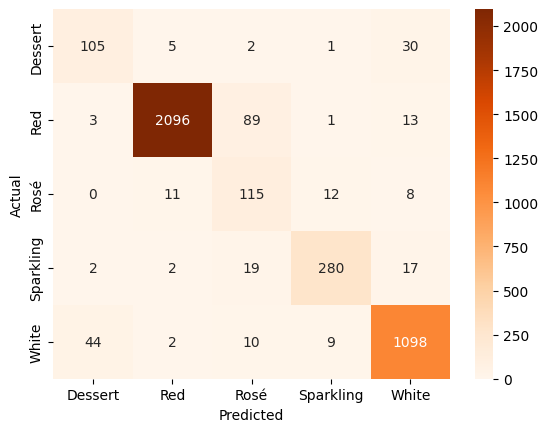

In [48]:
# Performance on the test set
score_model(clf, X_test_encoded_rf, y_test)

In [49]:
# Model improvement and AUC scores
rf_base, rf_best = calculate_AUC_scores(rf, clf, X_test_encoded_rf, y_test)

The AUC of the base model is: 0.949
The AUC of the best model is: 0.981
The improvement in performance is: 3.372%


### MLPClassifier

              precision    recall  f1-score   support

     Dessert       0.77      0.62      0.68       143
         Red       0.97      0.99      0.98      2202
        Rosé       0.75      0.62      0.68       146
   Sparkling       0.90      0.88      0.89       320
       White       0.95      0.96      0.95      1163

    accuracy                           0.94      3974
   macro avg       0.87      0.81      0.84      3974
weighted avg       0.94      0.94      0.94      3974



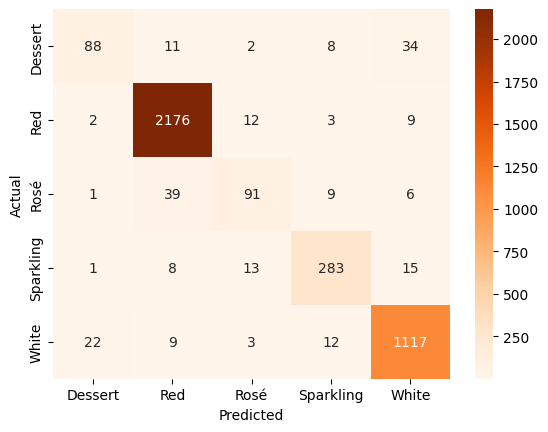

In [50]:
# Performance on the test set
score_model(clf1, X_test_encoded_nn, y_test)

In [51]:
# Model improvement and AUC scores
nn_base, nn_best = calculate_AUC_scores(nn, clf1, X_test_encoded_nn, y_test)

The AUC of the base model is: 0.954
The AUC of the best model is: 0.967
The improvement in performance is: 1.363%


### XGBClassifier

              precision    recall  f1-score   support

     Dessert       0.87      0.66      0.75       143
         Red       0.98      0.99      0.98      2202
        Rosé       0.75      0.63      0.69       146
   Sparkling       0.92      0.88      0.90       320
       White       0.94      0.98      0.96      1163

    accuracy                           0.95      3974
   macro avg       0.89      0.83      0.86      3974
weighted avg       0.95      0.95      0.95      3974



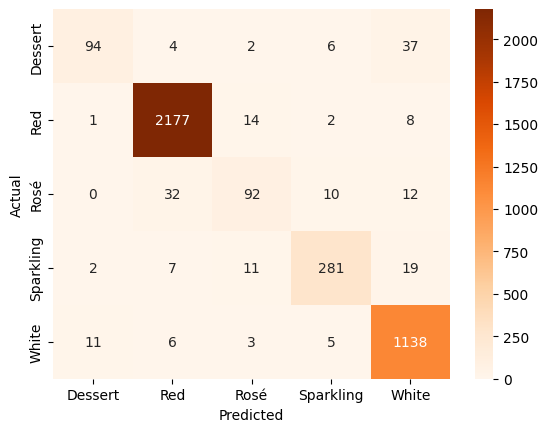

In [52]:
# Performance on test set
score_model(clf2, X_test_encoded_xgb, y_test)

In [53]:
# Model improvement and AUC scores
xgb_base, xgb_best = calculate_AUC_scores(xgb, clf2, X_test_encoded_xgb, y_test)

The AUC of the base model is: 0.969
The AUC of the best model is: 0.977
The improvement in performance is: 0.826%


Comparing the improvements in AUC scores before and after tuning of the 3 models, we can see that Random Forest Classifier has the largest improvement in performance after tuning with 3.37%

Comparing the confusion matrix and the classification reports of the 3 models, we can see that:
- All 3 models performed very well in predicting wine types as shown by their F1 scores
- MLPClassifier was better in predicting Red, Rosé, and White wines than the Random Forest Classifier
- Random Forest Classifier was better in predicting Dessert and Sparkling wines than the MLPClassifier

## Model Interpretation

### Random Forest

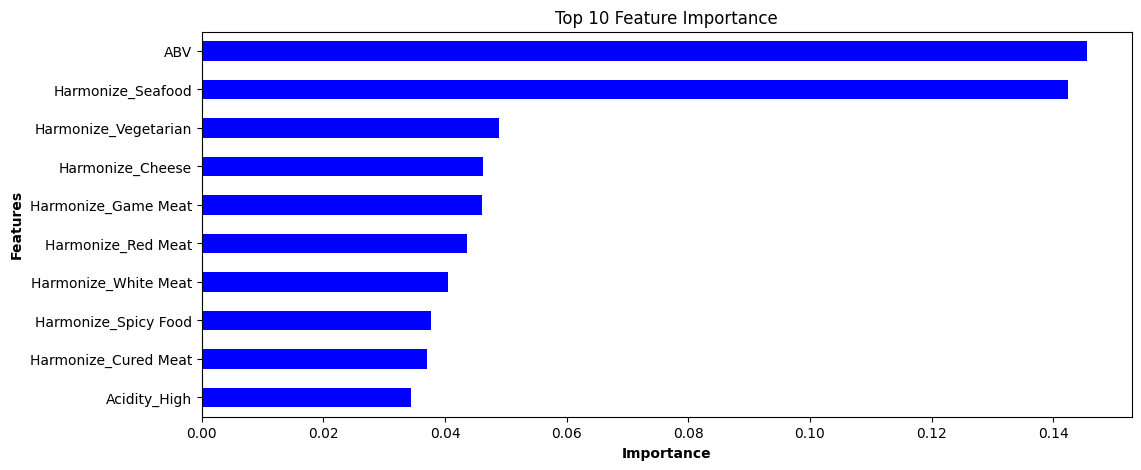

In [54]:
# helper function to get feature importance    
def plot_importance(model, X):

    importances = pd.Series(data=model.feature_importances_,
                            index= list(X.columns))
    
    importances_sorted = importances.sort_values()
    
    importances_sorted = importances_sorted[-10:]

    plt.figure(figsize = (12, 5))
    importances_sorted.plot(kind='barh', color='blue')
    plt.title('Top 10 Feature Importance')
    plt.xlabel("Importance", fontweight = 'bold')
    plt.ylabel("Features", fontweight = 'bold')
    plt.show()

plot_importance(rf_gs.best_estimator_.named_steps["random_forest"], X_train_encoded_rf)

### MLPClassifier

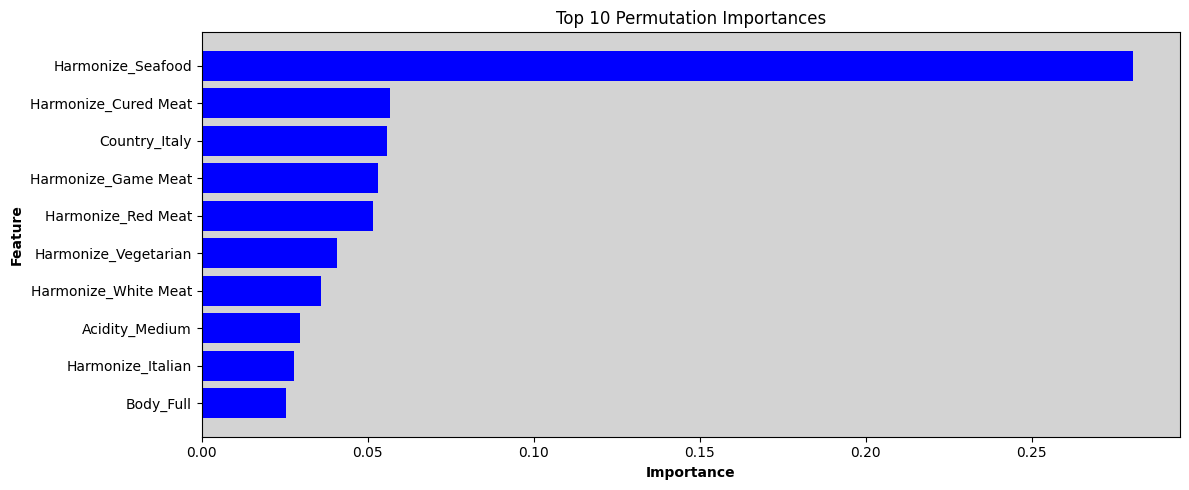

In [55]:
# plot feature importance
result = permutation_importance(clf1, X_test_encoded_nn, y_test, n_repeats = 10, random_state = 100)

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 5))
sorted_idx = result.importances_mean.argsort()[-10:]
ax.barh(X_test_encoded_nn.columns[sorted_idx], result.importances_mean[sorted_idx], color='blue')
ax.set_title("Top 10 Permutation Importances")
ax.set_facecolor('lightgrey')
ax.set_xlabel('Importance', fontweight = 'bold')
ax.set_ylabel('Feature', fontweight = 'bold')
ax.set_yticklabels(X_test_encoded_nn.columns[sorted_idx], fontsize=10)
fig.tight_layout()
plt.show()

### XGBClassifier

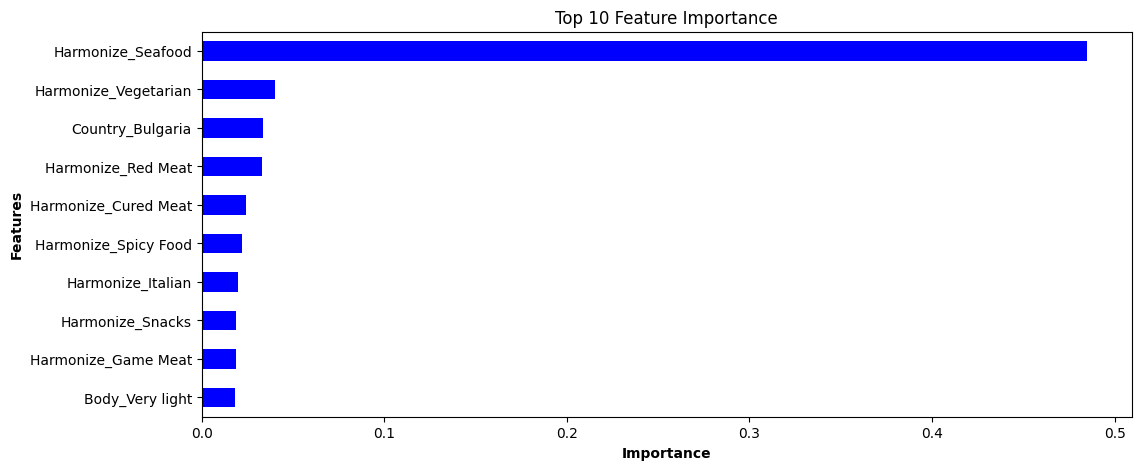

In [56]:
plot_importance(xgb_gs.best_estimator_.named_steps['xgb'], X_train_encoded_xgb)

For all 3 models, we can see that whether the wine harmonises with seafood is very important (Harmonize_Seafood) and would have a huge implication on the type of wine recommended. Random Forest seems to be the only model that places high importance on Alcohol by Volume (ABV).

## Model Comparison

In [57]:
# creating a dataframe to compare models
classifier = ['Random Forest', 'Multi-Layer Percepton', 'XGBoost']
scores = [rf_best, nn_best, xgb_best]

comparison = pd.DataFrame({'Model': classifier,
                           'AUC': scores})

comparison = comparison.sort_values(by='AUC', ascending = False).reset_index(drop=True)

comparison

,Model,AUC
0,Random Forest,0.981
1,XGBoost,0.977
2,Multi-Layer Percepton,0.967


We can see that among the 3 models, Random Forest outperforms the rest and thus it will be the model we will use for the Recommender Function